In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

!ls -lh /content/drive/MyDrive/car_damage_detection

total 1.4G
drwx------ 4 root root 4.0K Nov 23 15:49  data1a
-rw------- 1 root root  12M Dec  3 22:46  MobileNet_Car_detection_Final.keras
-rw------- 1 root root  21M Dec  4 00:17  MobileNet_Car_detection_FineTuned.keras
-rw------- 1 root root 265M Nov 23 17:16  testX.npy
-rw------- 1 root root 7.4K Nov 23 17:16  testY.npy
-rw------- 1 root root 1.1G Nov 23 17:16  trainX.npy
-rw------- 1 root root  29K Nov 23 17:16  trainY.npy
-rw------- 1 root root  12K Nov 23 19:18 'web_test(1).jpg'
-rw------- 1 root root 5.3K Nov 23 19:21 'web_test(2).jpg'
-rw------- 1 root root 9.8K Nov 23 19:24 'web_test(3).jpg'
-rw------- 1 root root 8.9K Nov 23 19:26 'web_test(4).jpg'
-rw------- 1 root root  13K Nov 23 19:27 'web_test(5).jpg'
-rw------- 1 root root  12K Nov 23 19:27 'web_test(6).jpg'
-rw------- 1 root root 8.2K Nov 23 19:28 'web_test(7).jpg'
-rw------- 1 root root 8.4K Nov 23 19:29 'web_test(8).jpg'
-rw------- 1 root root  43K Nov 23 19:11  web_test.jpg


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import keras

# Load your trained model
MODEL_PATH = "/content/drive/MyDrive/car_damage_detection/MobileNet_Car_detection_FineTuned.keras"
model = keras.models.load_model(MODEL_PATH)
print("[INFO] Model loaded successfully!")

[INFO] Model loaded successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 27 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Define Class Names
CATEGORIES = ["00-damage", "01-whole"]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


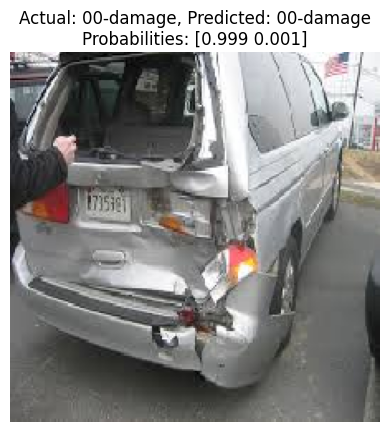

In [ ]:
#  Predict on a Training Image (sanity check)
# Randomly select one image from your training folders
train_dir = "/content/drive/MyDrive/car_damage_detection/data1a/training/"
categories = ["00-damage", "01-whole"]
category = random.choice(categories)
img_name = random.choice(os.listdir(os.path.join(train_dir, category)))
img_path = os.path.join(train_dir, category, img_name)

# Load and preprocess
image = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(image)
img_array = np.expand_dims(img_array, axis=0)
img_array = (img_array / 127.5) - 1.0   # normalization for MobileNetV2
threshold = 0.4

# Predict
pred = model.predict(img_array)[0]
label = categories[0] if pred[0] > threshold else categories[1]

# Show
plt.imshow(image)
plt.axis("off")
plt.title(f"Actual: {category}, Predicted: {label}\nProbabilities: {np.round(pred, 3)}")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras

tta_augment = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomTranslation(0.05, 0.05)
])

In [ ]:
def tta_predict(model, image, n=8, threshold=0.5):
    preds = []

    # expand dims once (image already normalized)
    img = tf.expand_dims(image, axis=0)

    for _ in range(n):
        aug_img = tta_augment(img, training=True)
        pred = model.predict(aug_img, verbose=0)[0]
        preds.append(pred)

    # average predictions
    mean_pred = np.mean(preds, axis=0)

    # apply your custom threshold to class 0 (damage)
    label = "00-damage" if mean_pred[0] > threshold else "01-whole"

    return mean_pred, label

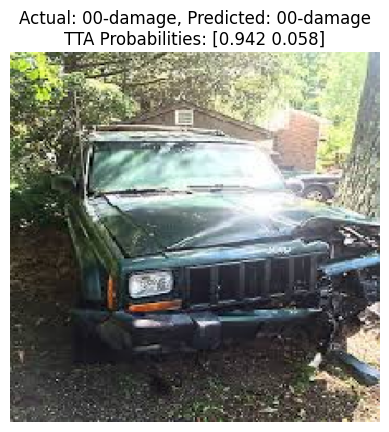

In [ ]:
#  Predict on a Validation Image (evaluation check)

# Pick a random validation image
val_dir = "/content/drive/MyDrive/car_damage_detection/data1a/validation"
categories = ["00-damage", "01-whole"]
category = random.choice(categories)
img_name = random.choice(os.listdir(os.path.join(val_dir, category)))
img_path = os.path.join(val_dir, category, img_name)

# Load + preprocess
image = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(image)
img_array = (img_array / 127.5) - 1.0   # your normalization

# TTA prediction (8 augmentations)
mean_pred, label = tta_predict(model, img_array, n=8, threshold=threshold)

# Display
plt.imshow(image)
plt.axis("off")
plt.title(f"Actual: {category}, Predicted: {label}\nTTA Probabilities: {np.round(mean_pred, 3)}")
plt.show()

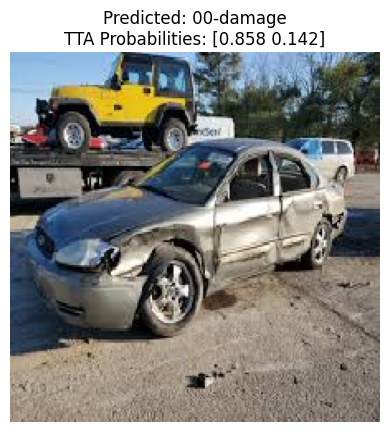

In [ ]:
#  Predict on a Web Image (real‑world test)

img_path = "/content/drive/MyDrive/car_damage_detection/web_test(5).jpg"

# Load and preprocess
image = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(image)
img_array = (img_array / 127.5) - 1.0    # your normalization

# Run TTA (8 augmented predictions)
mean_pred, label = tta_predict(model, img_array, n=8, threshold=threshold)

# Show result
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {label}\nTTA Probabilities: {np.round(mean_pred, 3)}")
plt.show()

In [ ]:
# Batch Testing

TEST_FOLDER = "/content/drive/MyDrive/car_damage_detection/data1a/validation/00-damage"  # or 01-whole

for img_name in os.listdir(TEST_FOLDER):
    img_path = os.path.join(TEST_FOLDER, img_name)
    image = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = (img_array / 127.5) - 1.0

    pred = model.predict(img_array)
    label = CATEGORIES[0] if pred[0, 0] > threshold else CATEGORIES[1]

    plt.imshow(image)
    plt.title(f"Prediction: {label}")
    plt.axis("off")
    plt.show()

In [ ]:
# Compute Metrics (Across a Test Set)

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

base_path = "/content/drive/MyDrive/car_damage_detection/data1a/validation"
data, labels = [], []

for category in CATEGORIES:
    folder = os.path.join(base_path, category)
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)
        img = load_img(fpath, target_size=(224, 224))
        x = img_to_array(img)
        x = preprocess_input(x)
        data.append(x)
        labels.append(category)

# Encode labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels_encoded = lb.fit_transform(labels)
labels_encoded = keras.utils.to_categorical(labels_encoded)

data = np.array(data, dtype="float32")
labels = np.array(labels_encoded)

# Predict
preds = model.predict(data)
y_true = np.argmax(labels, axis=1)
y_pred = np.where(preds[:, 0] > threshold, 0, 1)

print(classification_report(y_true, y_pred, target_names=CATEGORIES))

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
              precision    recall  f1-score   support

   00-damage       0.96      0.99      0.97       230
    01-whole       0.99      0.96      0.97       230

    accuracy                           0.97       460
   macro avg       0.97      0.97      0.97       460
weighted avg       0.97      0.97      0.97       460



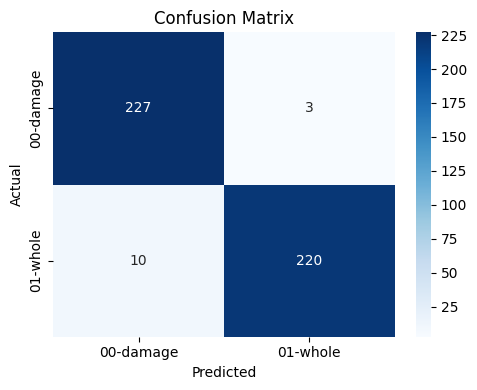

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs("results", exist_ok=True)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CATEGORIES,
            yticklabels=CATEGORIES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("results/confusion_matrix.png")
plt.show()
plt.close()
